# Twitter Example
In order to use all of this though, we need to setup a Developer API acocunt with Twitter and create an application to get credentials. Review the video for instructions on how to do this or if you are already familiar with it, just get the credentials from: 

    https://apps.twitter.com/
    
Once you have that you also need to install python-twitter, a python library to connect your Python to the twitter dev account.

You probably won't be able to run this example and then previous in the same notebook, you need to restart you kernel.

Let's get started!

Begin by running the TweetRead.py file. Make sure to add your own IP Adress and your credential keys.

In [1]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [3]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [4]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [5]:
lines = socket_stream.window( 20 )

In [6]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [7]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

__________
### Now run TweetRead.py
__________

In [8]:
ssc.start()    

In [9]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

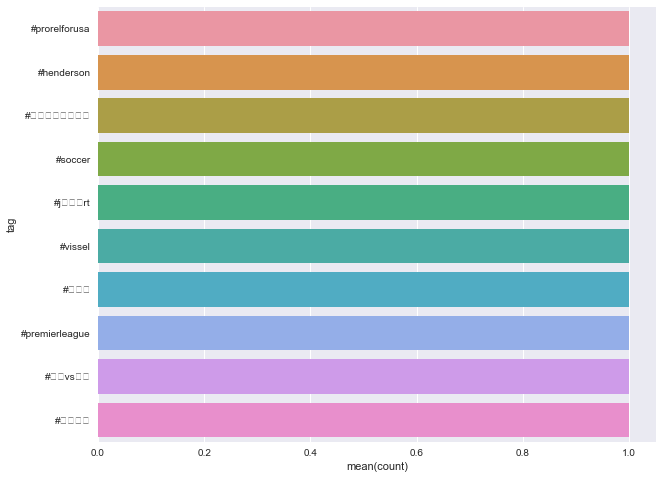

In [10]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    sns.plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    sns.plt.show()
    count = count + 1

In [11]:
ssc.stop()